In [1]:
import json
import os

from tqdm import tqdm
import pandas as pd
import jams
import librosa
import madmom
import crema
import pumpp
import mir_eval

Using TensorFlow backend.


In [2]:
def ann_to_label(ann):
    intervals, labels = ann.to_interval_values()
    dur_tracker = dict()

    for interval, label in zip(intervals, labels):
        dur = interval[1] - interval[0]
        if label not in dur_tracker:
            dur_tracker[label] = dur
        else:
            dur_tracker[label] += dur

    # return the key with the max value as the gloabl key_mode
    return max(dur_tracker, key=dur_tracker.get)


class MadmomKeyAnalyzer(object):
    def __init__(self):
        self.key_processor = madmom.features.key.CNNKeyRecognitionProcessor()

    def to_label(self, filename):
        return madmom.features.key.key_prediction_to_label(self.key_processor(filename))
    
    def to_ann(self, filename):
        label = self.to_label(filename)
        label = ':'.join(label.split(' '))
        file_dur = librosa.get_duration(filename=filename)
        ann = jams.Annotation(namespace='key_mode', time=0, duration=file_dur)
        ann.append(time=0, duration=file_dur, value=label)
        return ann


class CremaKeyAnalyzer(object):
    def __init__(self, model_weights='model.h5'):
        self.model = crema.models.key.KeyModel(model_weights=model_weights)
    
    def to_ann(self, filename):
        return self.model.predict(filename=filename)
    
    def to_label(self, filename):
        ann = self.to_ann(filename)
        label = ann_to_label(ann)
        return ' '.join(label.split(':'))

In [3]:
mka = MadmomKeyAnalyzer()
cka_gs = CremaKeyAnalyzer(model_weights='gs_model.h5')
cka_gs_aug = CremaKeyAnalyzer(model_weights='gs_aug_model.h5')

W0924 14:31:18.019973 4561851840 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0924 14:31:18.080755 4561851840 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0924 14:31:18.099468 4561851840 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0924 14:31:18.100186 4561851840 deprecation_wrapper.py:119] From /Users/tom/.pyenv/versions/miniconda3-latest/envs/keys/lib/python3.7/site-packages

In [6]:
f_name = librosa.util.example_audio_file()

m_label = mka.to_label(f_name)
c_label = cka.to_label(f_name)

In [7]:
m_label, c_label

('E major', 'E major')

## Next steps
- convert ground truth to label and to jams
- convert madmom label to jams and compare there
- *optional* convert crema jams to label and compare there

In [4]:
GS_HOME = "/Users/tom/Music/GuitarSet/"

gs_val_index = pd.read_json('dataset_indecies/gs_val_idx.json')[0]
gs_index = pd.read_json('dataset_indecies/guitarset_index.json')

In [9]:
def result_df_to_score_(result):
    t_score = 0
    m_score = 0
    c_score = 0
    ca_score = 0

    for track_id, row in result.iterrows():
        t_score += mir_eval.key.evaluate(reference_key=row.truth, estimated_key=row.truth)['Weighted Score']
        m_score += mir_eval.key.evaluate(reference_key=row.truth, estimated_key=row.madmom)['Weighted Score']
        c_score += mir_eval.key.evaluate(reference_key=row.truth, estimated_key=row.crema)['Weighted Score']
        ca_score += mir_eval.key.evaluate(reference_key=row.truth, estimated_key=row.crema_aug)['Weighted Score']

    print('weighted mirex scores:')
    print('\t madmom : {}'.format(m_score / t_score))
    print('\t crema  : {}'.format(c_score / t_score))
    print('\t crema_aug  : {}'.format(ca_score / t_score))

In [6]:
gs_index.keys()

Index(['audio_mic_comp', 'audio_mix_comp', 'jams_comp', 'audio_mic_solo',
       'audio_mix_solo', 'jams_solo', 'audio_mic_duo'],
      dtype='object')

In [8]:
# ONLY ON COMP
label_true = []
label_madmom = []
label_crema = []
label_crema_aug = []

for val_id in tqdm(gs_val_index):
    jam_path = os.path.join(GS_HOME, gs_index.jams_comp[val_id])
    mic_path = os.path.join(GS_HOME, gs_index.audio_mic_comp[val_id])
    
    ann_true = jams.load(jam_path).search(namespace='key_mode')[0]
    l_true = ann_to_label(ann_true)
    label_true.append(' '.join(l_true.split(':')))
    label_madmom.append(mka.to_label(mic_path))
    label_crema.append(cka_gs.to_label(mic_path))
    label_crema_aug.append(cka_gs_aug.to_label(mic_path))

gs_comp_result = pd.DataFrame(data={'truth':label_true, 'madmom':label_madmom, 'crema':label_crema, 'crema_aug':label_crema_aug}, 
                              index=gs_val_index)

result_df_to_score_(gs_comp_result)

100%|██████████| 36/36 [04:48<00:00,  7.22s/it]

weighted mirex scores:
	 madmom : 0.7000000000000001
	 crema  : 0.9388888888888888


In [10]:
result_df_to_score_(gs_comp_result)

weighted mirex scores:
	 madmom : 0.7000000000000001
	 crema  : 0.9388888888888888
	 crema_aug  : 0.8555555555555556


In [11]:
# ONLY ON SOLO
label_true = []
label_madmom = []
label_crema = []
label_crema_aug = []

for val_id in tqdm(gs_val_index):
    jam_path = os.path.join(GS_HOME, gs_index.jams_comp[val_id])
    mic_path = os.path.join(GS_HOME, gs_index.audio_mic_solo[val_id])
    
    ann_true = jams.load(jam_path).search(namespace='key_mode')[0]
    l_true = ann_to_label(ann_true)
    label_true.append(' '.join(l_true.split(':')))
    label_madmom.append(mka.to_label(mic_path))
    label_crema.append(cka_gs.to_label(mic_path))
    label_crema_aug.append(cka_gs_aug.to_label(mic_path))

gs_solo_result = pd.DataFrame(data={'truth':label_true, 'madmom':label_madmom, 'crema':label_crema, 'crema_aug':label_crema_aug}, 
                              index=gs_val_index)

result_df_to_score_(gs_solo_result)

100%|██████████| 36/36 [04:37<00:00,  7.10s/it]

weighted mirex scores:
	 madmom : 0.5444444444444446
	 crema  : 0.46388888888888896
	 crema_aug  : 0.4000000000000001


,audio_mic_comp,audio_mix_comp,jams_comp,audio_mic_solo,audio_mix_solo,jams_solo,audio_mic_duo
00_BN1-129-Eb,audio_mono-mic/00_BN1-129-Eb_comp_mic.wav,audio_mono-pickup_mix/00_BN1-129-Eb_comp_mix.wav,annotation/00_BN1-129-Eb_comp.jams,audio_mono-mic/00_BN1-129-Eb_solo_mic.wav,audio_mono-pickup_mix/00_BN1-129-Eb_solo_mix.wav,annotation/00_BN1-129-Eb_solo.jams,audio_mono-mic/00_BN1-129-Eb_duo_mic.wav
00_BN1-147-Gb,audio_mono-mic/00_BN1-147-Gb_comp_mic.wav,audio_mono-pickup_mix/00_BN1-147-Gb_comp_mix.wav,annotation/00_BN1-147-Gb_comp.jams,audio_mono-mic/00_BN1-147-Gb_solo_mic.wav,audio_mono-pickup_mix/00_BN1-147-Gb_solo_mix.wav,annotation/00_BN1-147-Gb_solo.jams,audio_mono-mic/00_BN1-147-Gb_duo_mic.wav
00_BN2-131-B,audio_mono-mic/00_BN2-131-B_comp_mic.wav,audio_mono-pickup_mix/00_BN2-131-B_comp_mix.wav,annotation/00_BN2-131-B_comp.jams,audio_mono-mic/00_BN2-131-B_solo_mic.wav,audio_mono-pickup_mix/00_BN2-131-B_solo_mix.wav,annotation/00_BN2-131-B_solo.jams,audio_mono-mic/00_BN2-131-B_duo_mic.wav
00_BN2-166-Ab,audio_mono-mic/00_BN2-166-Ab_comp_mic.wav,audio_mono-pickup_mix/00_BN2-166-Ab_comp_mix.wav,annotation/00_BN2-166-Ab_comp.jams,audio_mono-mic/00_BN2-166-Ab_solo_mic.wav,audio_mono-pickup_mix/00_BN2-166-Ab_solo_mix.wav,annotation/00_BN2-166-Ab_solo.jams,audio_mono-mic/00_BN2-166-Ab_duo_mic.wav
00_BN3-119-G,audio_mono-mic/00_BN3-119-G_comp_mic.wav,audio_mono-pickup_mix/00_BN3-119-G_comp_mix.wav,annotation/00_BN3-119-G_comp.jams,audio_mono-mic/00_BN3-119-G_solo_mic.wav,audio_mono-pickup_mix/00_BN3-119-G_solo_mix.wav,annotation/00_BN3-119-G_solo.jams,audio_mono-mic/00_BN3-119-G_duo_mic.wav
...,...,...,...,...,...,...,...
05_SS1-68-E,audio_mono-mic/05_SS1-68-E_comp_mic.wav,audio_mono-pickup_mix/05_SS1-68-E_comp_mix.wav,annotation/05_SS1-68-E_comp.jams,audio_mono-mic/05_SS1-68-E_solo_mic.wav,audio_mono-pickup_mix/05_SS1-68-E_solo_mix.wav,annotation/05_SS1-68-E_solo.jams,audio_mono-mic/05_SS1-68-E_duo_mic.wav
05_SS2-107-Ab,audio_mono-mic/05_SS2-107-Ab_comp_mic.wav,audio_mono-pickup_mix/05_SS2-107-Ab_comp_mix.wav,annotation/05_SS2-107-Ab_comp.jams,audio_mono-mic/05_SS2-107-Ab_solo_mic.wav,audio_mono-pickup_mix/05_SS2-107-Ab_solo_mix.wav,annotation/05_SS2-107-Ab_solo.jams,audio_mono-mic/05_SS2-107-Ab_duo_mic.wav
05_SS2-88-F,audio_mono-mic/05_SS2-88-F_comp_mic.wav,audio_mono-pickup_mix/05_SS2-88-F_comp_mix.wav,annotation/05_SS2-88-F_comp.jams,audio_mono-mic/05_SS2-88-F_solo_mic.wav,audio_mono-pickup_mix/05_SS2-88-F_solo_mix.wav,annotation/05_SS2-88-F_solo.jams,audio_mono-mic/05_SS2-88-F_duo_mic.wav
05_SS3-84-Bb,audio_mono-mic/05_SS3-84-Bb_comp_mic.wav,audio_mono-pickup_mix/05_SS3-84-Bb_comp_mix.wav,annotation/05_SS3-84-Bb_comp.jams,audio_mono-mic/05_SS3-84-Bb_solo_mic.wav,audio_mono-pickup_mix/05_SS3-84-Bb_solo_mix.wav,annotation/05_SS3-84-Bb_solo.jams,audio_mono-mic/05_SS3-84-Bb_duo_mic.wav


In [25]:
gs_solo_result.groupby('truth')\

,madmom,crema,crema_aug
truth,,,
A major,1,1,1
B major,1,1,1
Bb major,3,3,3
Bb minor,2,2,2
C major,3,3,3
C# major,8,8,8
D major,1,1,1
D minor,1,1,1
E major,4,4,4


## MIDI
- Test with idealized midi
- train with same data
- Synthenized methods

In [12]:
# ONLY ON DUO
label_true = []
label_madmom = []
label_crema = []
label_crema_aug = []

for val_id in tqdm(gs_val_index):
    jam_path = os.path.join(GS_HOME, gs_index.jams_comp[val_id])
    mic_path = os.path.join(GS_HOME, gs_index.audio_mic_duo[val_id])
    
    ann_true = jams.load(jam_path).search(namespace='key_mode')[0]
    l_true = ann_to_label(ann_true)
    label_true.append(' '.join(l_true.split(':')))
    label_madmom.append(mka.to_label(mic_path))
    label_crema.append(cka_gs.to_label(mic_path))
    label_crema_aug.append(cka_gs_aug.to_label(mic_path))

gs_duo_result = pd.DataFrame(data={'truth':label_true, 'madmom':label_madmom, 'crema':label_crema, 'crema_aug':label_crema_aug}, 
                             index=gs_val_index)

result_df_to_score_(c)

100%|██████████| 36/36 [04:54<00:00,  9.30s/it]

weighted mirex scores:
	 madmom : 0.7444444444444445
	 crema  : 0.9527777777777777
	 crema_aug  : 0.8722222222222222


In [20]:
gs_duo_result[gs_duo_result.crema != gs_duo_result.crema_aug]

,truth,madmom,crema,crema_aug
0,,,,
04_Jazz2-110-Bb,Bb minor,Db major,A# minor,C# major
05_Jazz1-130-D,D major,D major,C major,D major
00_Funk2-119-G,G minor,Bb major,G minor,D minor
02_Funk2-119-G,G minor,G minor,A# major,G minor
05_Jazz1-200-B,B major,E major,B major,E major
00_Jazz2-110-Bb,Bb minor,Db major,A# minor,C# major
01_BN3-119-G,G major,G major,G major,D major
05_Funk2-119-G,G minor,G minor,G minor,D minor
01_Jazz2-187-F#,F# minor,F# minor,F# minor,A major


## Next steps
- implement segment by segment key tag valuation.
- if it's not minor/major, then it's major.
- find more audio dataset to feed it
- do the MIDI dataset pipeline
- See how the structured output helps the model

In [13]:
AMAPS_HOME = '/Users/tom/Music/A-MAPS/'
val_index = pd.read_json('dataset_indecies/amaps_val_idx.json')[0]
amaps_index = pd.read_json('dataset_indecies/amaps_index.json')

In [14]:
amaps_index.index

Index(['MAPS_MUS-alb_esp2_AkPnCGdD', 'MAPS_MUS-alb_esp2_AkPnStgb',
       'MAPS_MUS-alb_esp2_SptkBGAm', 'MAPS_MUS-alb_esp2_SptkBGCl',
       'MAPS_MUS-alb_esp3_AkPnCGdD', 'MAPS_MUS-alb_esp4_AkPnStgb',
       'MAPS_MUS-alb_esp5_SptkBGCl', 'MAPS_MUS-alb_esp6_SptkBGCl',
       'MAPS_MUS-alb_se2_ENSTDkCl', 'MAPS_MUS-alb_se2_StbgTGd2',
       ...
       'MAPS_MUS-ty_november_ENSTDkAm', 'MAPS_MUS-ty_november_SptkBGCl',
       'MAPS_MUS-ty_oktober_SptkBGAm', 'MAPS_MUS-ty_september_AkPnStgb',
       'MAPS_MUS-ty_september_SptkBGAm', 'MAPS_MUS-waldstein_1_AkPnBsdf',
       'MAPS_MUS-waldstein_1_AkPnStgb', 'MAPS_MUS-waldstein_1_ENSTDkAm',
       'MAPS_MUS-waldstein_2_AkPnCGdD', 'MAPS_MUS-waldstein_3_SptkBGCl'],
      dtype='object', length=266)

In [15]:
label_true = []
label_madmom = []
label_crema = []
label_crema_aug = []

for track_id in tqdm(val_index):
    jam_path = os.path.join(AMAPS_HOME, amaps_index.jams[track_id])
    mic_path = os.path.join(AMAPS_HOME, amaps_index.audio[track_id])
    
    ann_true = jams.load(jam_path).search(namespace='key_mode')[0]
    l_true = ann_to_label(ann_true)
    label_true.append(' '.join(l_true.split(':')))
    label_madmom.append(mka.to_label(mic_path))
    label_crema.append(cka_gs.to_label(mic_path))
    label_crema_aug.append(cka_gs_aug.to_label(mic_path))

amaps_result = pd.DataFrame(data={'truth':label_true, 'madmom':label_madmom, 'crema':label_crema, 'crema_aug':label_crema_aug}, 
                            index=val_index)

result_df_to_score_(amaps_result)

 88%|████████▊ | 44/50 [25:36<02:01, 20.19s/it]
KeyboardInterrupt



In [43]:
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
amaps_result

In [29]:
model = cka_gs.model

In [57]:
aud_path = os.path.join(GS_HOME, gs_index.audio_mic_duo['04_Jazz2-110-Bb'])
jam_path = os.path.join(GS_HOME, gs_index.jams_solo['04_Jazz2-110-Bb'])

In [58]:
gs_output = cka_gs.model.outputs(filename=aud_path)
gs_aug_output = cka_gs_aug.model.outputs(filename=aud_path)

In [60]:
gs_feature = cka_gs_aug.model.pump.transform(audio_f=aud_path, jam=jam_path)

In [61]:
gs_feature.keys()

dict_keys(['chord_struct/pitch', 'chord_struct/root', 'chord_struct/bass', 'key_tag/tag', 'key_tag/_valid', 'key_struct/tonic', 'key_struct/pitch_profile', 'key_struct/_valid'])

In [65]:
gs_feature['chord_struct/pitch'].squeeze().shape

(375, 12)

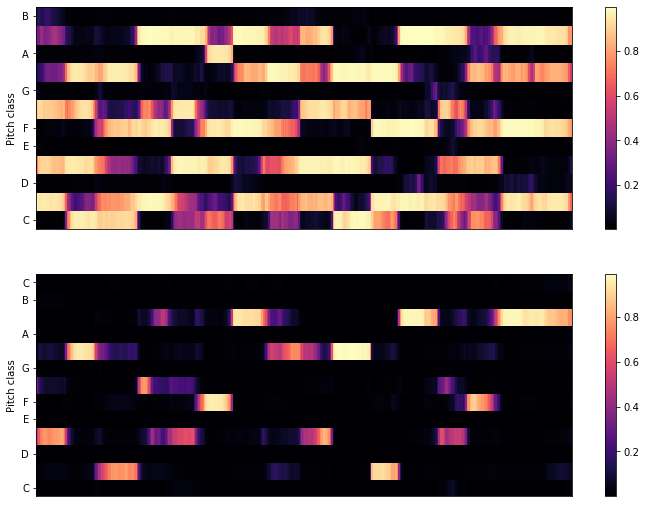

In [70]:
plt.figure(figsize=[12, 9])

plt.subplot(2, 1, 1)
librosa.display.specshow(gs_feature['chord_struct/pitch'].squeeze().T, y_axis='chroma')
plt.colorbar()
plt.subplot(2, 1, 2)
librosa.display.specshow(gs_feature['chord_struct/root'].squeeze().T, y_axis='chroma')
plt.colorbar()

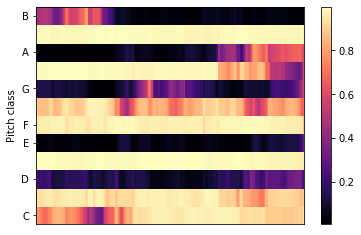

In [46]:
librosa.display.specshow(gs_aug_output['key_profile'].T, y_axis='chroma')
plt.colorbar()

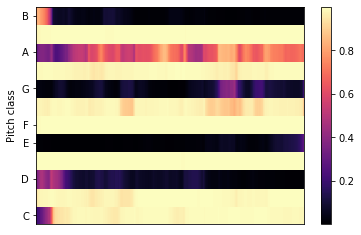

In [47]:
librosa.display.specshow(gs_output['key_profile'].T, y_axis='chroma')
plt.colorbar()

In [50]:
gs_output.keys()

dict_keys(['key_tag', 'key_tonic', 'key_profile'])

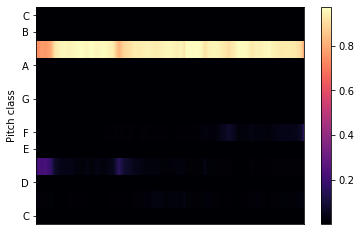

In [51]:
librosa.display.specshow(gs_output['key_tonic'].T, y_axis='chroma')
plt.colorbar()

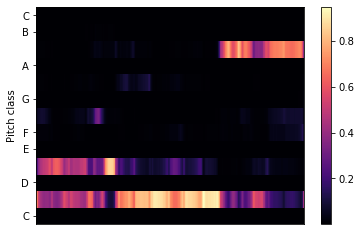

In [52]:
librosa.display.specshow(gs_aug_output['key_tonic'].T, y_axis='chroma')
plt.colorbar()

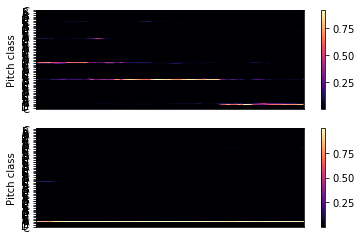

In [53]:
plt.subplot(2,1,1)

librosa.display.specshow(gs_aug_output['key_tag'].T, y_axis='chroma')
plt.colorbar()

plt.subplot(2,1,2)
librosa.display.specshow(gs_output['key_tag'].T, y_axis='chroma')
plt.colorbar()